In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!pip install spectral

     |████████████████████████████████| 184kB 26.7MB/s 
  Created wheel for spectral: filename=spectral-0.22.2-cp37-none-any.whl size=212955 sha256=00c12cc4f17fbbaf7e0de269fd57bb208355d1c0f3a8f4ba7bcb4bd9bdeac4a1
  Stored in directory: /root/.cache/pip/wheels/fb/00/da/ac778d1ab6e196cb7f56d104d4dfdfc0aad4e2b208275c0726
Successfully built spectral


In [4]:
import numpy as np
Xtrain = np.load('/content/gdrive/My Drive/indiana/Salians/x_train_Salianstest_ratio0.98windowSize25pca10.npy')
ytrain = np.load('/content/gdrive/My Drive/indiana/Salians/y_train_Salianstest_ratio0.98windowSize25pca10.npy')
Xtest = np.load('/content/gdrive/My Drive/indiana/Salians/x_test_Salianstest_ratio0.98windowSize25pca10.npy')
ytest = np.load('/content/gdrive/My Drive/indiana/Salians/y_test_Salianstest_ratio0.98windowSize25pca10.npy')

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv
from plotly.offline import init_notebook_mode
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral
init_notebook_mode(connected=True)
%matplotlib inline

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test

def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels
    


## GLOBAL VARIABLES
dataset = 'SA'
# test_ratio = 0.7
windowSize = 25
K = 10

In [6]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)

In [7]:
ytrain = np_utils.to_categorical(ytrain)
ytest = np_utils.to_categorical(ytest)

In [8]:
S = 25
L = K
input_layer = Input((S, S, L, 1))
output_units = 16
## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
# conv_layer1 = Conv3D(filters=16, kernel_size=(3, 3, 7), activation='relu')(input_layer)
# conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer1)

print(conv_layer3.get_shape())
conv3d_shape = conv_layer3.get_shape()
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=30)
# history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=20 , validation_data=(x_t, y_t))

model.save('/content/gdrive/My Drive/indiana/Pavia/my_model.h5')

(None, 19, 19, 4, 32)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25, 25, 10, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 23, 23, 8, 8)      224       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 21, 21, 6, 16)     3472      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 19, 19, 4, 32)     13856     
_________________________________________________________________
reshape (Reshape)            (None, 19, 19, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 17, 17, 64)        73792     
_________________________________________________________________
flatten (Flatten)            (None, 184

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/30
5/5 [==============================] - 32s 96ms/step - loss: 2.5292 - accuracy: 0.2209
Epoch 2/30
5/5 [==============================] - 0s 49ms/step - loss: 1.5026 - accuracy: 0.5129
Epoch 3/30
5/5 [==============================] - 0s 47ms/step - loss: 0.9419 - accuracy: 0.6987
Epoch 4/30
5/5 [==============================] - 0s 47ms/step - loss: 0.5897 - accuracy: 0.7976
Epoch 5/30
5/5 [==============================] - 0s 47ms/step - loss: 0.4108 - accuracy: 0.8540
Epoch 6/30
5/5 [==============================] - 0s 50ms/step - loss: 0.3455 - accuracy: 0.8762
Epoch 7/30
5/5 [==============================] - 0s 48ms/step - loss: 0.2479 - accuracy: 0.9187
Epoch 8/30
5/5 [==============================] - 0s 47ms/step - loss: 0.1760 - accuracy: 0.9325
Epoch 9/30
5/5 [==============================] - 0s 49ms/step - loss: 0.2200 - accuracy: 0.9335
Epoch 10/30
5/5 [==============================] - 0s 50ms/step - loss: 0.1355 - accuracy: 0.9547
Epoch 11/30
5/5 [===========

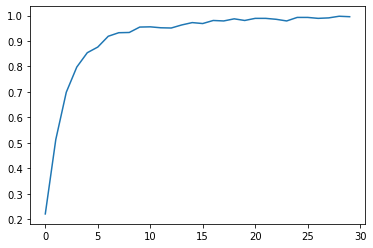

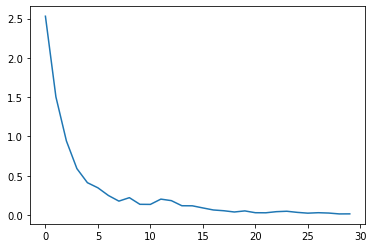

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1969
           1       1.00      1.00      1.00      3652
           2       1.00      1.00      1.00      1936
           3       1.00      1.00      1.00      1366
           4       1.00      1.00      1.00      2624
           5       1.00      1.00      1.00      3880
           6       1.00      1.00      1.00      3507
           7       1.00      0.99      0.99     11046
           8       1.00      1.00      1.00      6079
           9       1.00      1.00      1.00      3212
          10       1.00      0.98      0.99      1047
          11       1.00      1.00      1.00      1888
          12       1.00      0.96      0.98       898
          13       0.97      1.00      0.98      1049
          14       0.98      0.99      0.99      7123
          15       1.00      1.00      1.00      1771

    accuracy                           1.00     53047
   macro avg       1.00   

In [9]:
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train acc', 'val_accuracy'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val_loss'], loc='upper left')
plt.show()


model.load_weights('/content/gdrive/My Drive/indiana/Pavia/my_model.h5')
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


# Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
# ytest = np_utils.to_categorical(ytest)

import warnings
warnings.filterwarnings('always')

Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)


classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

In [10]:
dataset = 'SA'
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc


def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        # target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn']
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
                        
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100



classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "/content/gdrive/My Drive/indiana/Pavia/classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))


def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    return patch

1658/1658 [==============================] - 7s 4ms/step - loss: 0.0157 - accuracy: 0.9953


In [11]:
t = sio.loadmat('/content/gdrive/My Drive/indiana/Salians/Salinas_corrected.mat')
f = sio.loadmat('/content/gdrive/My Drive/indiana/Salians/Salinas_gt.mat')
X = t['salinas_corrected']
y = f['salinas_gt']

In [12]:
height = y.shape[0]
width = y.shape[1]

PATCH_SIZE = windowSize
numComponents = K

X,pca = applyPCA(X, numComponents=numComponents)
X = padWithZeros(X, PATCH_SIZE//2)

# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

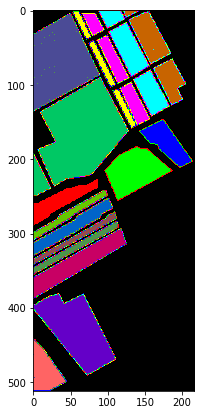

In [13]:
import spectral
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

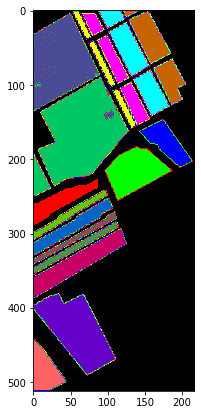

In [14]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))
